In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import pickle
import random
import gzip
import json
import zstd
import polars as pl
import time

**NOTE:**
- For out initial analysis to detect bots, we chose data from year 2018 since it had the highest number of comments (covering 20% of total data).
- Most of the users in the provided comments dataset have only a single comments (as shown in the plots below). So, we had to filter out active users.
- We considered users with at least a total of 100 comments to have sufficient data to distinguish between regular active users and bots.
- We choose 100 as the threshold since mean of total comments per user is 19 with S.D of 140. Meanwhile, bots usually comment in thousands and more. So, to consider active users we set a threshold of comments count going above around half a S.D over mean (100). This gives us a good conservative threshold to proceed making our data analysis easy since comments data is huge containing mostly single comment user entries.

In [2]:
%%time
# Load youtube videos metadata dataset (to get 'upload_date')
df_metadata_feather = pd.read_feather("./data/yt_metadata_helper.feather")
df_metadata_feather = df_metadata_feather[['display_id', 'upload_date']]
df_metadata_feather.rename(columns={"display_id":"video_id"}, inplace=True)

# Convert df_metadata_feather to a Polars DataFrame
df_metadata_polars = pl.from_pandas(df_metadata_feather).with_columns(
    pl.col("upload_date").dt.date().alias("upload_date")  # Keep only the date part (removes 00:00:00)
)

del df_metadata_feather # remove Pandas df from memory since not used

df_metadata_polars.head()

CPU times: user 26.7 s, sys: 18.2 s, total: 44.9 s
Wall time: 38.4 s


video_id,upload_date
str,date
"""SBqSc91Hn9g""",2016-09-28
"""UuugEl86ESY""",2016-09-28
"""oB4c-yvnbjs""",2016-09-28
"""ZaV-gTCMV8E""",2016-09-28
"""cGvL7AvMfM0""",2016-09-28


In [3]:
%%time
# Create filtered authors df
threshold_comments = 100
num_comments_authors_orignial = pd.read_csv("./data/num_comments_authors.tsv.gz", compression="infer", sep="\t")
authors_bot_df = num_comments_authors_orignial[num_comments_authors_orignial["video_id"]>threshold_comments]
authors_bot_df_polars = pl.from_pandas(authors_bot_df[["author"]])

del authors_bot_df # remove Pandas df from memory since not used

before_size = num_comments_authors_orignial.shape[0]
after_size = authors_bot_df_polars.shape[0]
print(f"before:\t{before_size}\nafter:\t{after_size}\nchange:\t{before_size/after_size:.1f} times")

before:	448810483
after:	15386449
change:	29.2 times
CPU times: user 45.2 s, sys: 4.78 s, total: 49.9 s
Wall time: 50.1 s


In [4]:
# Metadata for videos from year 2018 
df_metadata_polars_2018 = df_metadata_polars.filter(
    pl.col("upload_date").dt.year() == 2018
).with_columns(
    pl.col("upload_date").dt.date().alias("upload_date")  # Keep only the date part
)

In [ ]:
%%time
# Create dataset

import os
import time

i = 0
chunksize = 100_000_000
processed_rows= 0
start_time = time.time()  # Record the start time
file_path = "author_comments_per_video_2018.parquet"

file_exists = os.path.exists(file_path) 
print(f"'{file_path}' exists? {file_exists}")

'''
NOTE: total_rows in youtube_comments.tsv.gz = 8_610_000_000
'''

for df in  pd.read_csv("./data/youtube_comments.tsv.gz", compression="infer", sep="\t", chunksize=chunksize): # chunksize = # of rows
    print("\nprocessing df chunk...")
    try:
        q = (
            pl.from_pandas(df)
            .lazy()  # Convert to lazy frame
            .group_by(['author', 'video_id'])
            .agg(
                comments=pl.col('video_id').count(),  # Count of video_id for each group
                likes=pl.col('likes').sum(),         # Sum of likes for each group
                replies=pl.col('replies').sum()      # Sum of replies for each group
            )
        )
    except Exception as e:
        print(f"Error encountered: {e}")
        print("Attempting to coerce non-numeric values and retry...")
        
        # Convert specific columns to numeric, coercing errors to NaN
        df['replies'] = pd.to_numeric(df['replies'], errors='coerce', downcast="integer").dropna().astype('int64')
        df['likes'] = pd.to_numeric(df['likes'], errors='coerce', downcast="integer").dropna().astype('int64')

        # Retry loading into Polars
        q = (
            pl.from_pandas(df)
            .lazy()
            .group_by(['author', 'video_id'])
            .agg(
                comments=pl.col('video_id').count(),
                likes=pl.col('likes').sum(),
                replies=pl.col('replies').sum()
            )
        )
    
    df_polars = q.collect()
        
    # consider only 2018 data
    df_polars = df_polars.join(df_metadata_polars_2018, on="video_id", how="inner")
    
    # filter authors
    df_polars = df_polars.join(authors_bot_df_polars, on="author", how="inner")
    df_polars = df_polars.sort(by='author')
    df_polars = df_polars[["author", "video_id", "upload_date","comments","likes","replies"]]


    df_polars = df_polars.with_columns([
        pl.col("replies").cast(pl.Int64)
    ])
    df_polars = df_polars.with_columns([
        pl.col("likes").cast(pl.Int64)
    ])

    # Write the first chunk or append the next chunks
    if not file_exists:
        # Write the first chunk with header
        df_polars.write_parquet(file_path, compression='zstd')
        print(f"'{file_path}' saved.")
        file_exists = True
    else:
        # For subsequent chunks, load the existing Feather file, & overwrite it with updated data (append don't work with feather)
        print(f"reading '{file_path}'...")
        df_existing = pl.read_parquet(file_path, low_memory=True)
        df_combined = pl.concat([df_existing, df_polars])
        df_combined.write_parquet(file_path, compression='zstd')
        print(f"saved '{file_path}'. ")

    
    # Track the number of processed rows
    processed_rows += chunksize

    # Display progress
    print(f"iteration:{i+1}, processed_rows: {processed_rows:_}")
    i += 1

    current_time = time.time()     # Record the end time
    elapsed_time = current_time - start_time
    elapsed_hours = int(elapsed_time // 3600)
    elapsed_minutes = int((elapsed_time % 3600) // 60)
    elapsed_seconds = int(elapsed_time % 60)
    print(f"Elapsed time: {elapsed_hours:02}:{elapsed_minutes:02}:{elapsed_seconds:02}\n")


# Read Dataset (Parquet)

In [2]:
%%time
# Read dataset parquet using pandas
dataset_df = pd.read_parquet("author_comments_per_video_2018.parquet")


CPU times: user 3min 39s, sys: 1min 44s, total: 5min 24s
Wall time: 5min 5s


#### OR

In [2]:
%%time
# Read dataset parquet using polars (much faster!)
dataset_df = pl.read_parquet("author_comments_per_video_2018.parquet", low_memory=True)


CPU times: user 1min 20s, sys: 1min 39s, total: 3min
Wall time: 15.4 s


In [3]:
dataset_df.head()

author,video_id,upload_date,comments,likes,replies
i64,str,date,u32,i64,i64
16,"""s9sgU7fWlV4""",2018-11-17,1,0,0
16,"""ujdUh7ZfkUY""",2018-07-08,1,6,0
16,"""OaLFcwHzPaA""",2018-12-27,1,1,0
16,"""aQoD6KfXZqg""",2018-03-21,1,0,0
16,"""Croosu_XdF4""",2018-07-14,1,0,0


# Why we chose year 2018 for intial analysis?

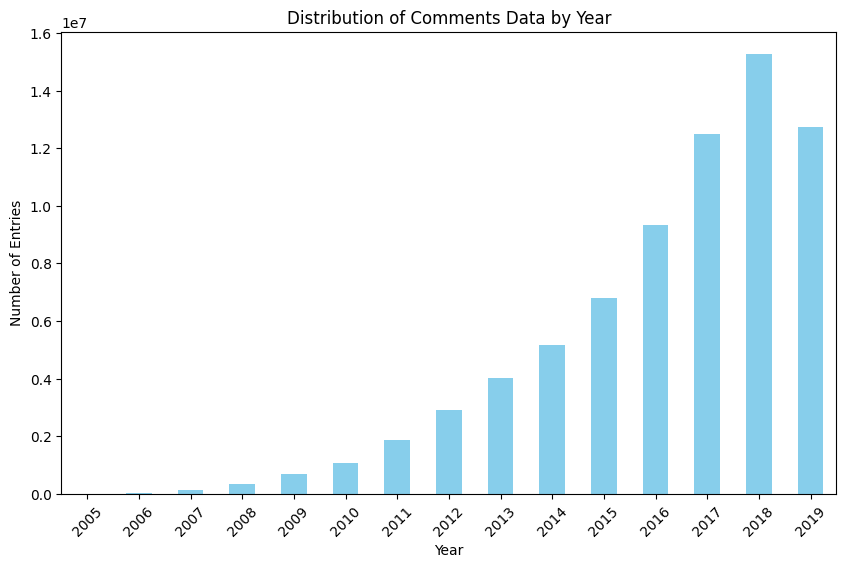

Percentage of data following 2017: 84.78%


In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the year from 'upload_date'
df_metadata_feather['year'] = df_metadata_feather['upload_date'].dt.year

# Count the occurrences for each year
year_counts = df_metadata_feather['year'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(10, 6))
year_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Comments Data by Year')
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45)
plt.show()

# Count number of entries for years above 2012
year = 2017
entries_above_year = len(df_metadata_feather[df_metadata_feather['year'] >= 2014])
total_entries = len(df_metadata_feather)

# Calculate the percentage
percentage_above_year = (entries_above_year / total_entries) * 100

print(f"Percentage of data following {year}: {percentage_above_year:.2f}%")

# Some Preliminary Analyis on Random Sample (10 million lines)

- Users post comments on 1.29 different videos on average, with maximum being 840.
- Users post 1.3 comments under a single video on average, with maximum being ~2000.

In [103]:
# Group by author and upload_date, then count the number of videos commented on daily by each author

df_pandas = df_polars.to_pandas()
daily_comments_df = df_pandas.groupby(['author', 'upload_date']).size().reset_index(name='videos_commented_daily')
daily_comments_df = daily_comments_df.sort_values(by=['author', 'upload_date'])
print(daily_comments_df.head())

print("\nstats for 'videos_commented_daily':")
daily_comments_df['videos_commented_daily'].describe()

    author upload_date  videos_commented_daily
0  2660153  2006-04-03                       1
1  2660153  2006-07-19                       1
2  2660153  2006-08-24                       1
3  2660153  2006-10-24                       1
4  2660153  2006-11-07                       2

stats for 'videos_commented_daily':


count    3.597351e+06
mean     1.290115e+00
std      8.106885e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      8.400000e+01
Name: videos_commented_daily, dtype: float64

In [86]:
# Find avg # of comments made by an author under a single video
df_pandas["comments"].describe()

count    4.640995e+06
mean     1.300615e+00
std      2.535739e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.017000e+03
Name: comments, dtype: float64

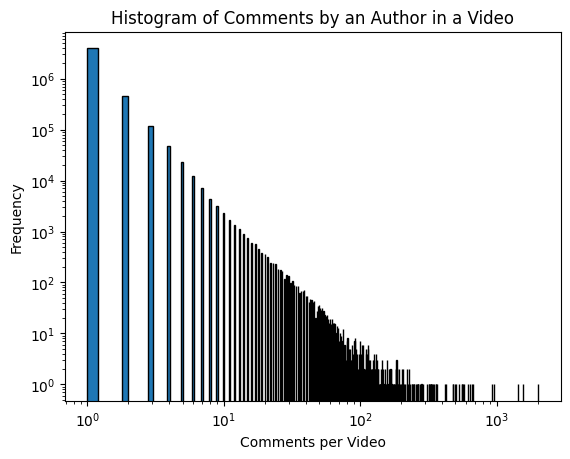

In [95]:
# plot histogram of # of comments made by an author under a single video

df_pandas["comments"].plot.hist(bins=10000, edgecolor='black')

# Add titles and labels
plt.title('Histogram of Comments by an Author in a Video')
plt.xlabel('Comments per Video')
plt.ylabel('Frequency')

# Set the x-axis to logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Show the plot
plt.show()


# Why We Filtered Authors with Total Comments > 100 

In [36]:
%%time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

num_comments_authors_orignial = pd.read_csv("./data/num_comments_authors.tsv.gz", compression="infer", sep="\t")
num_comments_authors_orignial.head() # NOTE: "video_id" is actually total # of comments made by author!

CPU times: user 44 s, sys: 15.3 s, total: 59.3 s
Wall time: 1min 2s


,author,video_id
0,1,5
1,2,3
2,3,2
3,4,6
4,5,3


In [90]:
# find median and mean total comments by an author in entire dataset
mean_comms = num_comments_authors_orignial["video_id"].mean()
median_comms = num_comments_authors_orignial["video_id"].median()
std_comms = num_comments_authors_orignial["video_id"].std()
print(f"mean: {mean_comms}, std: {std_comms}, median: {median_comms}")

mean: 19.174283032511074, std: 140.6533593518982, median: 2.0


In [91]:
# How much data (i-e authors) does 2xStd covers?
filtered_df = num_comments_authors_orignial[(num_comments_authors_orignial["video_id"]<2*std_comms)]
coverage = (len(filtered_df)/len(num_comments_authors_orignial)*100)
print(f"<2xStd coverage: {coverage:.1f}%")

<2xStd coverage: 98.9%


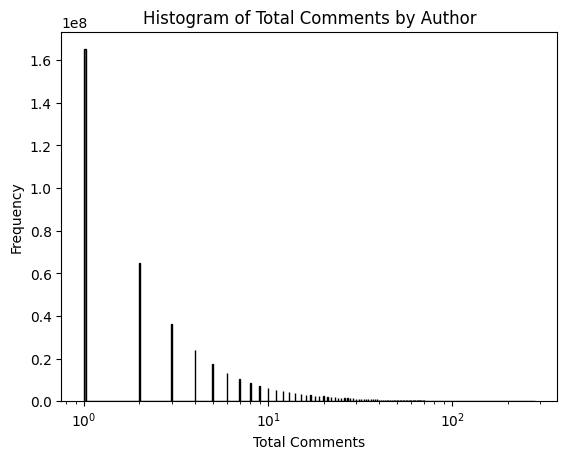

CPU times: user 25.1 s, sys: 24.9 s, total: 50 s
Wall time: 51.2 s


In [93]:
%%time
# Plot distribution of total comments
import matplotlib.pyplot as plt

# to remove outliers
filtered_df = num_comments_authors_orignial[(num_comments_authors_orignial["video_id"]<2*std_comms)]

# Create a histogram of the 'video_id' column
filtered_df['video_id'].plot.hist(bins=10000, edgecolor='black')

# Add titles and labels
plt.title('Histogram of Total Comments by Author')
plt.xlabel('Total Comments')
plt.ylabel('Frequency')

# Set the x-axis to logarithmic scale
plt.xscale('log')

# Show the plot
plt.show()

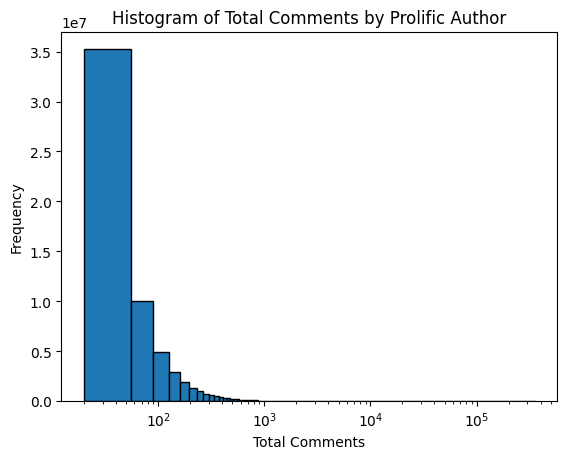

CPU times: user 11 s, sys: 2.19 s, total: 13.2 s
Wall time: 22.5 s


In [94]:
%%time
# Plot distribution for active/prolific authors who comment a lot
import matplotlib.pyplot as plt

# to remove outliers
filtered_df = num_comments_authors_orignial[(num_comments_authors_orignial["video_id"]>mean_comms)]

# Create a histogram of the 'video_id' column
filtered_df['video_id'].plot.hist(bins=10000, edgecolor='black')

# Add titles and labels
plt.title('Histogram of Total Comments by Prolific Author')
plt.xlabel('Total Comments')
plt.ylabel('Frequency')

# Set the x-axis to logarithmic scale
plt.xscale('log')
#plt.yscale('log')

# Show the plot
plt.show()

#### Why filter authors intially with some threshold 'k'?
- Avg total comments by an author = 19
- Bots usually comment in 100s per video or even more
- Even if a bot targets only a single video, it typically has comments in 100s
- So, initially filtering at mean + SD = ~100 reduces size of the dataset and makes it easier to process
- Filtered data would contain: (1) prolific/active users that comment frequently (2) bots that spam comments
- The real challenge is differentiating between the both.

